In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pylab as plt
import zipfile
import os
import cv2
import torchvision
from torchvision import datasets, models, transforms
import time
from torchvision.models import inception_v3
from sklearn.metrics import classification_report,confusion_matrix
from torch.utils.data import DataLoader, random_split
from sklearn.manifold import TSNE
import sklearn.metrics as metrics
import numpy as np

In [3]:

from google.colab import drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/Datasets'

# zip_file_path = 'drive/My Drive/Datasets'

with zipfile.ZipFile(zip_file_path + '/Dataset_2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Define your dataset directory
dataset_dir = '/content/Dataset_2'




# Load the dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(dataset_dir)
# Construct class labels and their corresponding folder paths
class_labels = []
for folder in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, folder)) and not folder.endswith('.DS_Store'):
        for subfolder in os.listdir(os.path.join(dataset_dir, folder)):
            if not subfolder.endswith('.DS_Store'):
                class_labels.append((f"{folder}_{subfolder}", os.path.join(dataset_dir, folder, subfolder)))

# Set the dataset classes and class_to_idx
dataset.classes = [label for label, _ in class_labels]
dataset.class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}

# Print the number of classes and their names
print(f"The number of classes is: {len(dataset.classes)}")
print(f"The classes are: {dataset.classes}")

Mounted at /content/drive
The number of classes is: 16
The classes are: ['Mango (P0)_healthy', 'Mango (P0)_diseased', 'Jamun (P5)_healthy', 'Jamun (P5)_diseased', 'Gauva (P3)_healthy', 'Gauva (P3)_diseased', 'Alstonia Scholaris (P2)_healthy', 'Alstonia Scholaris (P2)_diseased', 'Arjun (P1)_healthy', 'Arjun (P1)_diseased', 'Jatropha (P6)_healthy', 'Jatropha (P6)_diseased', 'Chinar (P11)_healthy', 'Chinar (P11)_diseased', 'Lemon (P10)_healthy', 'Lemon (P10)_diseased']


In [4]:
# Define the size of the training, validation, and test sets
# Define the sizes of train, validation sets
train_size = int(0.7 * len(dataset))   # 70% of the dataset for training
val_size = int(0.1 * len(dataset))   # Remaining 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for testing

# Split the dataset into train, validation, and test sets
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to match Inception input size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transformations to train and test datasets
train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform
test_dataset.dataset.transform = valid_transform

# Create DataLoader for batching and shuffling data
train_batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

# Create DataLoader for batching and shuffling data
valid_batch_size = 32
valid_data_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)
test_batch_size = 32
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

2155
307
617


In [5]:
# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = len(dataset.classes)
print(num_classes)
print(dataset.classes)

# Define the Inception model
model = models.inception_v3(pretrained=False, aux_logits=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

16
['Mango (P0)_healthy', 'Mango (P0)_diseased', 'Jamun (P5)_healthy', 'Jamun (P5)_diseased', 'Gauva (P3)_healthy', 'Gauva (P3)_diseased', 'Alstonia Scholaris (P2)_healthy', 'Alstonia Scholaris (P2)_diseased', 'Arjun (P1)_healthy', 'Arjun (P1)_diseased', 'Jatropha (P6)_healthy', 'Jatropha (P6)_diseased', 'Chinar (P11)_healthy', 'Chinar (P11)_diseased', 'Lemon (P10)_healthy', 'Lemon (P10)_diseased']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [6]:
# Lists to store accuracy and loss
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

t1 = time.time()
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

    # Validate the model
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss /= len(valid_data_loader)
    valid_losses.append(valid_loss)
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    print(f"Epoch {epoch+1}, Validate Loss: {valid_loss}, Validate Accuracy: {valid_accuracy}")

print("######## Training and Validatation Finished in {} seconds ###########".format(time.time()-t1))

Epoch 1, Train Loss: 1.1394733072203749, Train Accuracy: 62.87703016241299
Epoch 1, Validate Loss: 1.3876140236854553, Validate Accuracy: 64.82084690553746
Epoch 2, Train Loss: 0.4271014332771301, Train Accuracy: 87.09976798143852
Epoch 2, Validate Loss: 0.3123217821121216, Validate Accuracy: 91.53094462540717
Epoch 3, Train Loss: 0.25154563412070274, Train Accuracy: 92.5754060324826
Epoch 3, Validate Loss: 0.5740378737449646, Validate Accuracy: 84.36482084690553
Epoch 4, Train Loss: 0.23413705803892193, Train Accuracy: 92.5754060324826
Epoch 4, Validate Loss: 0.21426537856459618, Validate Accuracy: 92.50814332247558
Epoch 5, Train Loss: 0.2116042637704488, Train Accuracy: 93.36426914153132
Epoch 5, Validate Loss: 0.19891904816031455, Validate Accuracy: 94.13680781758957
Epoch 6, Train Loss: 0.13708368940826723, Train Accuracy: 95.63805104408353
Epoch 6, Validate Loss: 0.28267207331955435, Validate Accuracy: 92.50814332247558
Epoch 7, Train Loss: 0.09039287267403458, Train Accuracy: 96

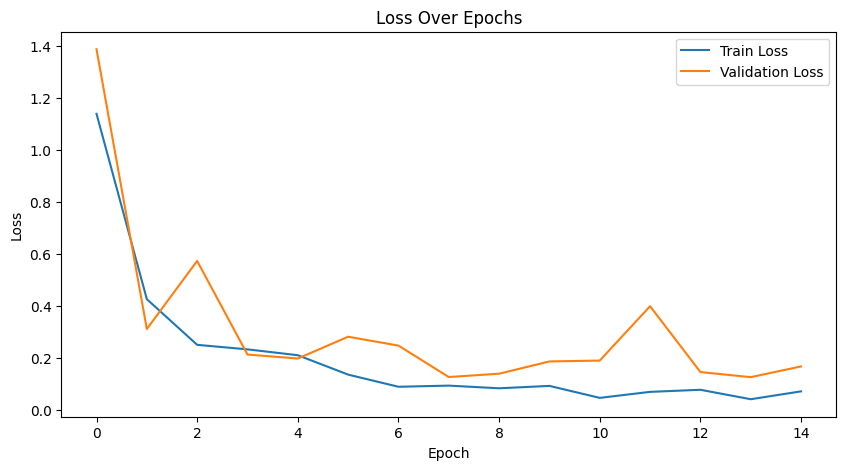

In [7]:
# Generate predictions
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in valid_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot loss
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

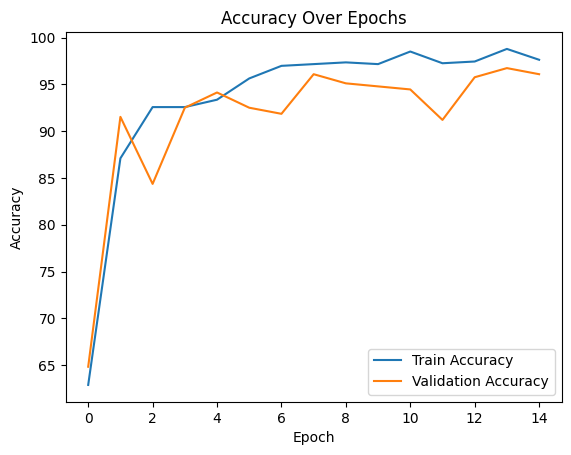

In [8]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [9]:
# Generate classification report
class_report = classification_report(all_labels, all_preds)
print(class_report)
# Generate classification matrix
class_matrix = confusion_matrix(all_labels, all_preds)
print(class_matrix)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        42
           1       0.95      0.98      0.97        43
           2       1.00      1.00      1.00        24
           3       1.00      0.96      0.98        49
           4       0.89      1.00      0.94        66
           5       1.00      0.96      0.98        24
           6       0.92      0.96      0.94        24
           7       1.00      0.97      0.99        35

    accuracy                           0.96       307
   macro avg       0.97      0.96      0.96       307
weighted avg       0.96      0.96      0.96       307

[[36  1  0  0  3  0  2  0]
 [ 0 42  0  0  1  0  0  0]
 [ 0  0 24  0  0  0  0  0]
 [ 0  0  0 47  2  0  0  0]
 [ 0  0  0  0 66  0  0  0]
 [ 0  0  0  0  1 23  0  0]
 [ 0  0  0  0  1  0 23  0]
 [ 0  1  0  0  0  0  0 34]]


In [10]:
# Generate predictions on test data
all_preds_test = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())
accuracy = metrics.accuracy_score(all_labels_test, all_preds_test)
print("Accuracy:", accuracy)

Accuracy: 0.9384116693679092


In [11]:
# Generate classification report of test dataset
class_report_test = classification_report(all_labels_test, all_preds_test)
print(class_report_test)
# Generate classification matrix of test dataset
class_matrix_test = confusion_matrix(all_labels, all_preds)
print(class_matrix_test)

              precision    recall  f1-score   support

           0       0.99      0.87      0.92        89
           1       0.89      0.99      0.93        78
           2       0.96      0.96      0.96        45
           3       0.97      0.87      0.92        78
           4       0.84      1.00      0.91       120
           5       1.00      0.91      0.95        44
           6       1.00      0.93      0.96        54
           7       1.00      0.95      0.98       109

    accuracy                           0.94       617
   macro avg       0.95      0.93      0.94       617
weighted avg       0.95      0.94      0.94       617

[[36  1  0  0  3  0  2  0]
 [ 0 42  0  0  1  0  0  0]
 [ 0  0 24  0  0  0  0  0]
 [ 0  0  0 47  2  0  0  0]
 [ 0  0  0  0 66  0  0  0]
 [ 0  0  0  0  1 23  0  0]
 [ 0  0  0  0  1  0 23  0]
 [ 0  1  0  0  0  0  0 34]]


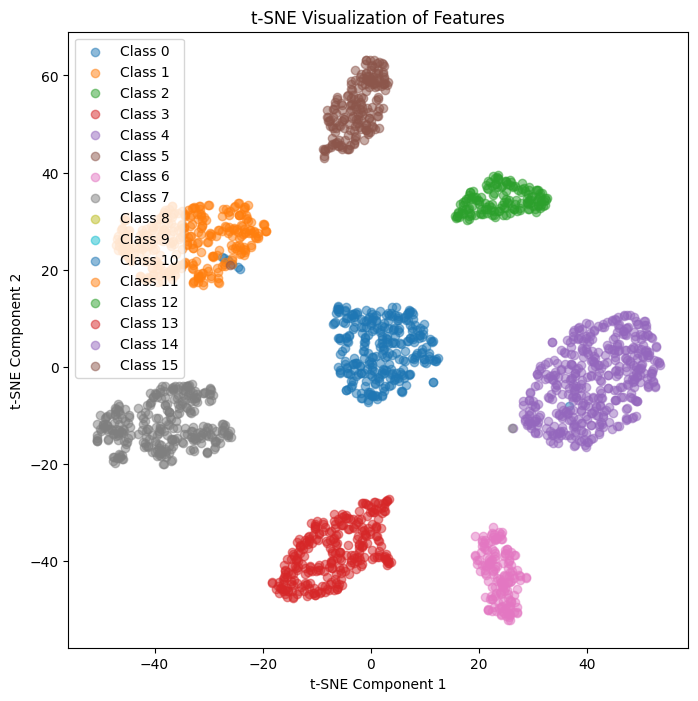

In [12]:
# Get features from the penultimate layer of the Inception model
features = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

features = np.array(features)
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(num_classes):
    plt.scatter(embedded_features[np.array(all_labels_test) == class_idx, 0],
                embedded_features[np.array(all_labels_test) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

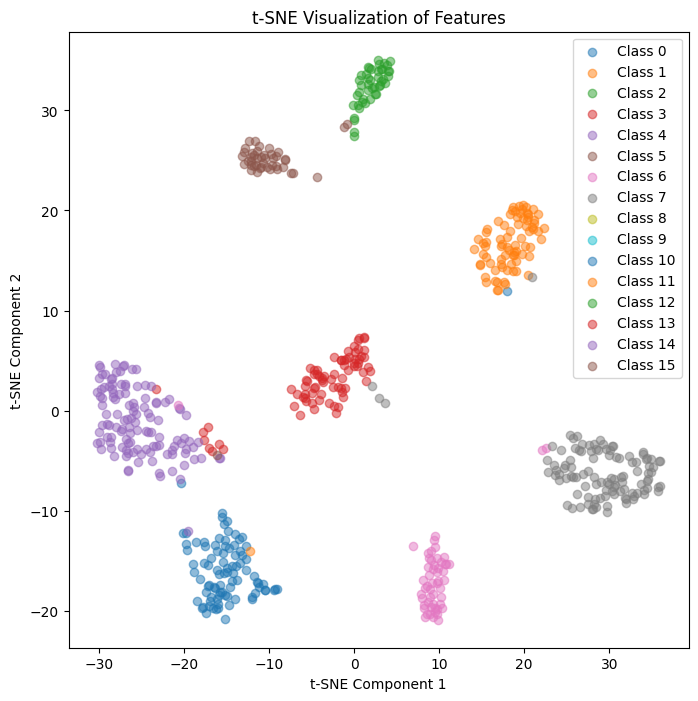

In [13]:
# Get features from the penultimate layer of the Inception model
features = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

features = np.array(features)
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(num_classes):
    plt.scatter(embedded_features[np.array(all_labels_test) == class_idx, 0],
                embedded_features[np.array(all_labels_test) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()